In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython import display
display.set_matplotlib_formats("svg")
from torch.utils.data import DataLoader, TensorDataset

C:\Users\Admin\AppData\Local\Temp\ipykernel_3596\1930260902.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")


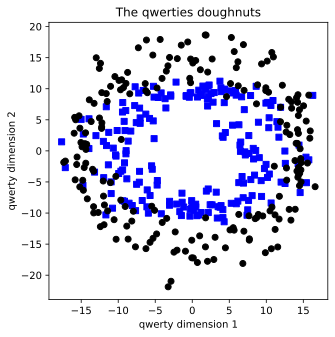

In [3]:
# create data

nPerClust = 200

th = np.linspace(0, 4*np.pi, nPerClust)
r1 = 10
r2 = 15

# generate data
a = [ r1*np.cos(th) + np.random.randn(nPerClust) * 3,
      r1*np.sin(th) + np.random.randn(nPerClust) ]
b = [ r2*np.cos(th) + np.random.randn(nPerClust),
      r2*np.sin(th) + np.random.randn(nPerClust) * 3 ]

# true labels
labels_np = np.vstack((np.zeros((nPerClust, 1)), np.ones((nPerClust, 1))))

# concatenate into a matrix
data_np = np.hstack((a, b)).T
labels = torch.tensor(labels_np).float()

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize = (5, 5))
plt.plot(data[np.where(labels == 0)[0], 0], data[np.where(labels == 0)[0], 1], "bs")
plt.plot(data[np.where(labels == 1)[0], 0], data[np.where(labels == 1)[0], 1], "ko")
plt.title("The qwerties doughnuts")
plt.xlabel("qwerty dimension 1")
plt.ylabel("qwerty dimension 2")
plt.show()

In [4]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = .2)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# finally translate into dataloader objects
batchsize = 16
train_loader = DataLoader(train_data, shuffle = True, batch_size = batchsize)
test_loader = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0]) # this is not split up and batch size = 1

In [5]:
class theModelClass(nn.Module):
    def __init__(self, dropoutRate):
        super().__init__()

        # layers
        self.input = nn.Linear(2, 128)
        self.hidden = nn.Linear(128, 128)
        self.output = nn.Linear(128, 1)

        # parameters
        self.dr = dropoutRate

    # forward pass
    def forward(self, x):

        # pass the data thru te input layer
        x = F.relu(self.input(x))

        # dropout after input layer
        x = F.dropout(x, p = self.dr, training = self.training) # self.training is set to True when model is in train mode and it is set to false when model is in eval mode

        # pass the data thru the hidden layer
        x = F.relu(self.hidden(x))

        # dropout after hidden layer
        x = F.dropout(x, p = self.dr, training = self.training)

        # output layer
        x = self.output(x)
        # nodropout here

        return x

In [6]:
# test the model
tmpnet = theModelClass(.25)

# run thru some random data
tmpdata = torch.randn((10, 2))
yhat = tmpnet(tmpdata)
yhat

tensor([[ 0.0303],
        [ 0.0744],
        [-0.0290],
        [ 0.0016],
        [ 0.0306],
        [ 0.2930],
        [-0.0184],
        [ 0.0693],
        [ 0.2300],
        [ 0.0484]], grad_fn=<AddmmBackward0>)

In [7]:
def createANewModel(dropoutrate):
    # grab an instance of the model class
    ANNQC = theModelClass(dropoutrate)

    # loss function
    lossfun = nn.BCEWithLogitsLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANNQC.parameters(), lr = .002)

    return ANNQC, lossfun, optimizer

In [8]:
# train the model

# training parameter
numepochs = 1000

def trainTheModel(ANNQC, lossfun, optimizer):
    trainAcc = []
    testAcc = []
    
    # train the model
    for epochi in range(numepochs):

        # switch training mode on
        ANNQC.train()

        # loop over training data batches
        batchAcc = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = ANNQC(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute training accuracy just for this batch
            batchAcc.append(100 * torch.mean(((yHat > .5) == y).float()).item())

        # now that we've trained through the batches, get avg training accuracy
        trainAcc.append(np.mean(batchAcc))

        # test accuracy
        ANNQC.eval() # switch training off
        X, y = next(iter(test_loader))  # extract X, y from test dataloader
        yHat = ANNQC(X)
        testAcc.append(100 * torch.mean(((yHat > .5) == y).float()).item())

    # function output
    return trainAcc, testAcc

In [9]:
# create a model
dropoutrate = .0
ANNQC, lossfun, optimizer = createANewModel(dropoutrate)

# train the model
trainAcc, testAcc = trainTheModel(ANNQC, lossfun, optimizer)

In [10]:
# create a 1D smoothing filter
def smooth(x, k = 5):
    return np.convolve(x, np.ones(k)/k, mode = "same")

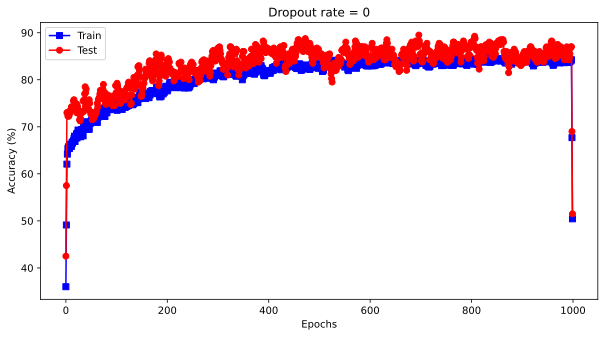

In [12]:
# plot the results
fig = plt.figure(figsize = (10, 5))

plt.plot(smooth(trainAcc), "bs-")
plt.plot(smooth(testAcc), "ro-")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(["Train", "Test"])
plt.title("Dropout rate = %g" %dropoutrate)

plt.show()

In [13]:
# run an experiment

dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates), 2))

for di in range(len(dropoutRates)):

    # create and train model
    ANNQC, lossfun, optimizer = createANewModel(dropoutRates[di])
    trainAcc, testAcc = trainTheModel(ANNQC, lossfun, optimizer)

    # store the accuracies from last 100 epochs
    results[di, 0] = np.mean(trainAcc[-100:])
    results[di, 1] = np.mean(testAcc[-100:])

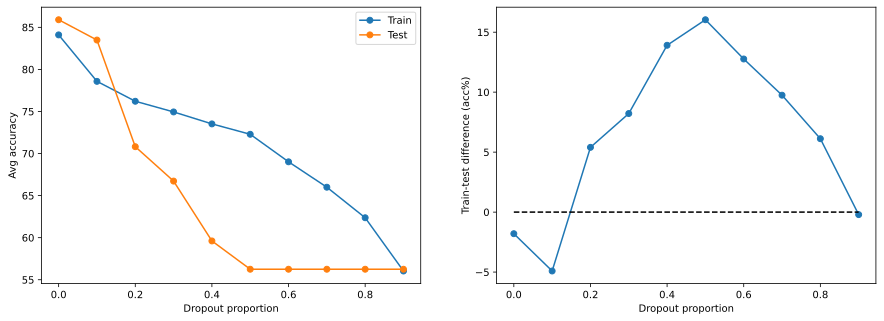

In [15]:
# plot the experiment results
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].plot(dropoutRates, results, "o-")
ax[0].set_xlabel("Dropout proportion")
ax[0].set_ylabel("Avg accuracy")
ax[0].legend(["Train", "Test"])

ax[1].plot(dropoutRates, -np.diff(results, axis = 1), "o-")
ax[1].plot([0, .9], [0, 0], "k--")
ax[1].set_xlabel("Dropout proportion")
ax[1].set_ylabel("Train-test difference (acc%)")

plt.show()